# Model Comparisons

## Configurations

In [1]:
%matplotlib inline
import os
import errno
import warnings
import numpy as np
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
# Deal with the bold roman font bug, see
#   https://github.com/matplotlib/matplotlib/issues/5574
matplotlib.font_manager._rebuild()
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.size'] = 12.0
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

In [3]:
SMOOTH = 'med' # 'med', 'avg', None
RESULT_DIR = './figs/'
EXTENSION = 'png' # 'pdf', 'ps', 'eps', 'svg'
EXP_DIRS = [
    '../exp/wgangp/g_bn_relu_bn_softmax_d_ln_relu',
    '../exp/wgangp/g_bn_relu_none_softmax_d_none_relu',
    '../exp/wgangp/g_bn_relu_bn_softmax_d_none_relu',
    '../exp/wgangp/g_bn_relu_none_none_d_none_relu',
    '../exp/wgangp/g_bn_relu_bn_none_d_none_relu',
    '../exp/wgangp/g_none_relu_none_softmax_d_none_relu',
    '../exp/wgangp/g_none_relu_none_none_d_none_relu',
    '../exp/wgangp/g_bn_relu_bn_softmax_d_bn_relu',
]

## Utilities

In [4]:
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

def movingaverage(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

def color_variant(hex_color, brightness_offset=1):
    """Takes a hex color code and produces a lighter or darker variant."""
    if len(hex_color) != 7:
        raise ValueError("Unrecognizable color code. Should be like #5F4B8B.")
    rgb_hex = [hex_color[x:x+2] for x in [1, 3, 5]]
    rgb_int = [int(hex_value, 16) + brightness_offset for hex_value in rgb_hex]
    rgb_int = [min([255, max([0, i])]) for i in rgb_int] 
    return "#" + "".join(['{:0>2}'.format(hex(i)[2:]) for i in rgb_int])

In [5]:
def plot_loss_curve(step, loss, smooth=None, window=5, filepath=None, **kwargs):
    """Plot a traning loss curve."""
    if smooth is None:
        plt.semilogy(step, loss, '-', **kwargs)
    else:
        plt.semilogy(step, loss, '-', linewidth=.15, color='0.7')
        if smooth == 'med':
            h = (k - 1)//2
            smoothed = scipy.signal.medfilt(loss, k)[h:-h]
            plt.semilogy(step[h:-h], smoothed, '-', **kwargs)
        elif smooth == 'avg':
            h = (k - 1)//2
            plt.semilogy(step, movingaverage(loss, k), '-', **kwargs)
    if filepath is not None:
        plt.savefig(filepath, bbox_inches='tight')

def plot_acc_curve(step, loss, smooth=None, window=5, label=None, filepath=None, **kwargs):
    """Plot an accuracy curve."""
    if smooth is None:
        plt.plot(step, loss, '-', label=label, **kwargs)
    else:
        line = plt.plot(step, loss, '-', linewidth=.15, zorder=0)
        if smooth == 'med':
            h = (window - 1)//2
            smoothed = scipy.signal.medfilt(loss, window)[h:-h]
            plt.plot(step[h:-h], smoothed, '-', label=label, color=line[0].get_color(), **kwargs)
        elif smooth == 'avg':
            h = (window - 1)//2
            plt.plot(step[h:-h], movingaverage(loss, window), '-', label=label, color=line[0].get_color(), **kwargs)
        line[0].set_color(color_variant(line[0].get_color(), 50))

### Load Data

In [6]:
test_steps, test_losses, train_steps, train_losses = [], [], [], []
for exp_dir in EXP_DIRS:
    # Load test accuracies
    filepath = os.path.join(exp_dir, 'logs', 'train', 'val_acc.log')
    test_steps.append(np.loadtxt(filepath, int, delimiter=',', usecols=(0)))
    test_losses.append(np.loadtxt(filepath, float, delimiter=',', usecols=(1)))
    # Load training accuracies
    filepath = os.path.join(exp_dir, 'logs', 'train', 'train_losses.log')
    train_steps.append(np.loadtxt(filepath, int, delimiter=',', usecols=(0)))
    train_losses.append(np.loadtxt(filepath, float, delimiter=',', usecols=(3)))

### Performance Table

In [7]:
for i, exp_dir in enumerate(EXP_DIRS):
    print("{:40} {:.4}".format(os.path.basename(EXP_DIRS[i]), test_losses[i].max()))

g_bn_relu_bn_softmax_d_ln_relu           0.9557
g_bn_relu_none_softmax_d_none_relu       0.9489
g_bn_relu_bn_softmax_d_none_relu         0.9353
g_bn_relu_none_none_d_none_relu          0.9253
g_bn_relu_bn_none_d_none_relu            0.9252
g_none_relu_none_softmax_d_none_relu     0.9218
g_none_relu_none_none_d_none_relu        0.8914
g_bn_relu_bn_softmax_d_bn_relu           0.8615


### Test Accuracy Plots

In [8]:
make_sure_path_exists(RESULT_DIR)

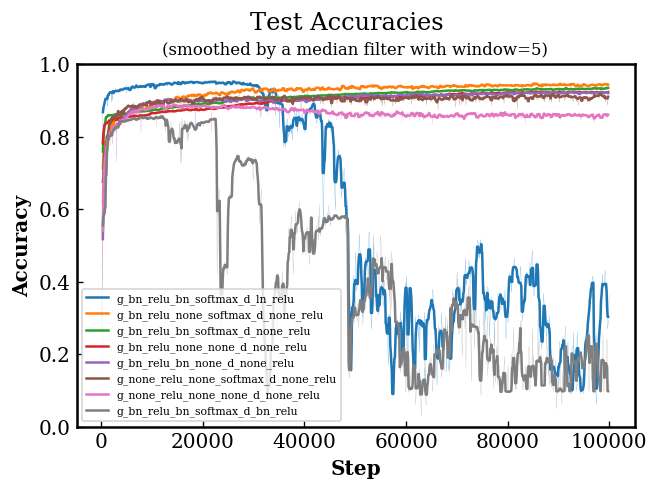

In [9]:
window = 5
for i, exp_dir in enumerate(EXP_DIRS):
    plot_acc_curve(test_steps[i], test_losses[i], smooth='med', window=window, label=os.path.basename(exp_dir))
plt.ylim(0, 1)
plt.gcf().suptitle('Test Accuracies', y=0.99)
plt.title('(smoothed by a median filter with window={})'.format(window), fontsize=10)
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.tick_params(direction='in')
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.legend(loc=3, prop={'size':6.5})
plt.savefig(os.path.join(RESULT_DIR, 'test_acc.{}'.format(EXTENSION)), bbox_inches='tight')
plt.show()

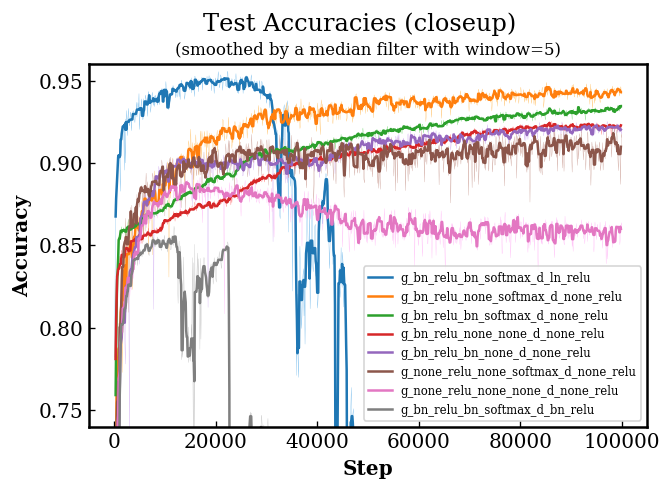

In [10]:
window = 5
for i, exp_dir in enumerate(EXP_DIRS):
    plot_acc_curve(test_steps[i], test_losses[i], smooth='med', window=window, label=os.path.basename(exp_dir))
plt.ylim(0.74, 0.96)
plt.gcf().suptitle('Test Accuracies (closeup)', y=0.99)
plt.title('(smoothed by a median filter with window={})'.format(window), fontsize=10)
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.yticks(np.arange(0.75, 0.99, 0.05))
plt.tick_params(direction='in')
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.legend(loc=4, prop={'size':7})
plt.savefig(os.path.join(RESULT_DIR, 'test_acc_closeup.{}'.format(EXTENSION)), bbox_inches='tight')
plt.show()

### Training Accuracy Plots

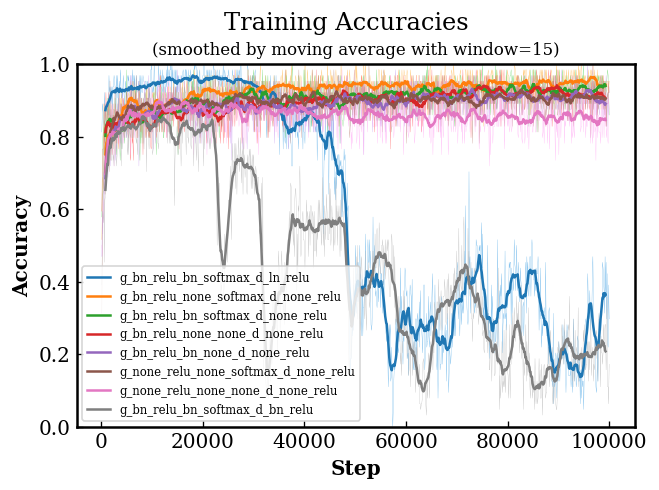

In [11]:
window = 15
for i, exp_dir in enumerate(EXP_DIRS):
    plot_acc_curve(train_steps[i], train_losses[i], smooth='avg', window=window, label=os.path.basename(exp_dir))
plt.ylim(0, 1)
plt.tick_params(direction='in')
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.gcf().suptitle('Training Accuracies', y=0.99)
plt.title('(smoothed by moving average with window={})'.format(window), fontsize=10)
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.legend(loc=3, prop={'size':7})
plt.savefig(os.path.join(RESULT_DIR, 'train_acc.{}'.format(EXTENSION)), bbox_inches='tight')
plt.show()

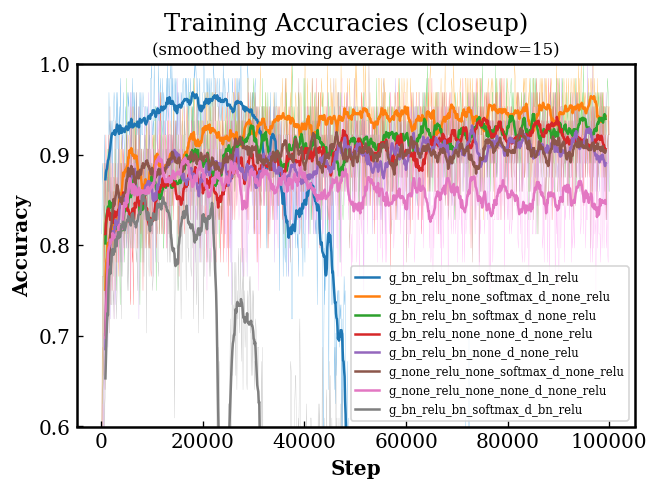

In [12]:
window = 15
for i, exp_dir in enumerate(EXP_DIRS):
    plot_acc_curve(train_steps[i], train_losses[i], smooth='avg', window=window, label=os.path.basename(exp_dir))
plt.ylim(0.6, 1)
plt.gcf().suptitle('Training Accuracies (closeup)', y=0.99)
plt.title('(smoothed by moving average with window={})'.format(window), fontsize=10)
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.yticks(np.arange(0.6, 1.01, 0.1))
plt.tick_params(direction='in')
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.legend(loc=4, prop={'size':7})
plt.savefig(os.path.join(RESULT_DIR, 'train_acc_closeup.{}'.format(EXTENSION)), bbox_inches='tight')
plt.show()

## Normalization in Generator

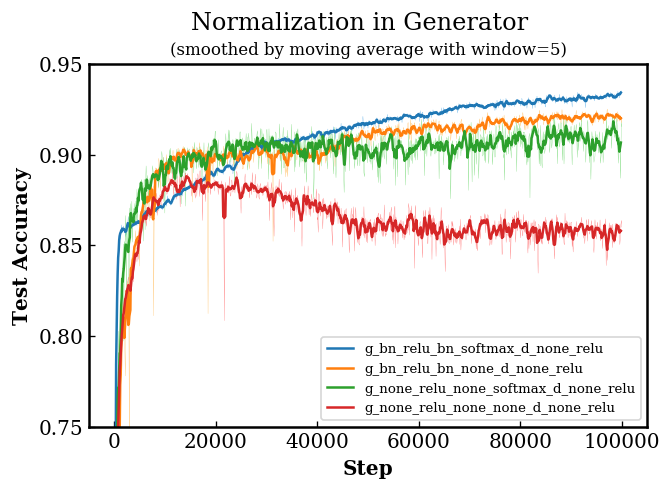

In [13]:
window = 5
for i in [2, 4, 5, 6]:
    plot_acc_curve(test_steps[i], test_losses[i], smooth='avg', window=window, label=os.path.basename(EXP_DIRS[i]))
plt.gcf().suptitle('Normalization in Generator', y=0.99)
plt.ylim(0.75, 0.95)
plt.title('(smoothed by moving average with window={})'.format(window), fontsize=10)
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Test Accuracy', fontweight='bold')
plt.yticks(np.arange(0.75, 0.955, 0.05))
plt.tick_params(direction='in')
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.legend(prop={'size':8})
plt.savefig(os.path.join(RESULT_DIR, 'norm_in_g.{}'.format(EXTENSION)), bbox_inches='tight')
plt.show()

## Output Normalization and Activation in Generator

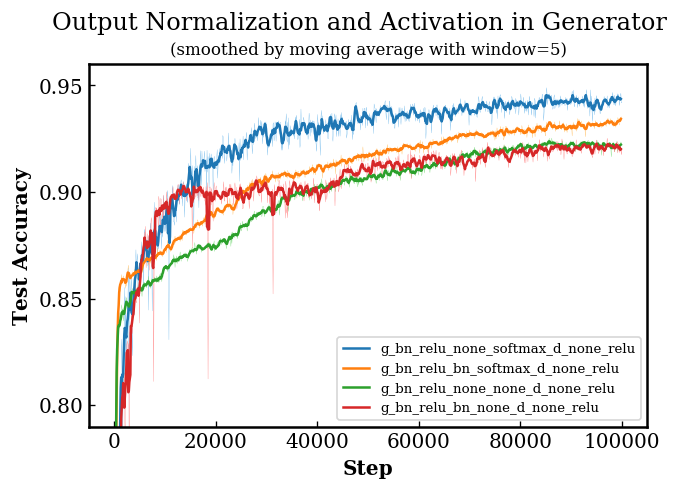

In [14]:
window = 5
for i in [1, 2, 3, 4]:
    plot_acc_curve(test_steps[i], test_losses[i], smooth='avg', window=window, label=os.path.basename(EXP_DIRS[i]))
plt.gcf().suptitle('Output Normalization and Activation in Generator', y=0.99)
plt.ylim(0.79, 0.96)
plt.title('(smoothed by moving average with window={})'.format(window), fontsize=10)
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Test Accuracy', fontweight='bold')
plt.yticks(np.arange(0.8, 0.955, 0.05))
plt.tick_params(direction='in')
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.legend(prop={'size':8})
plt.savefig(os.path.join(RESULT_DIR, 'out_norm_act_in_g.{}'.format(EXTENSION)), bbox_inches='tight')
plt.show()

## Normalization in Discriminator

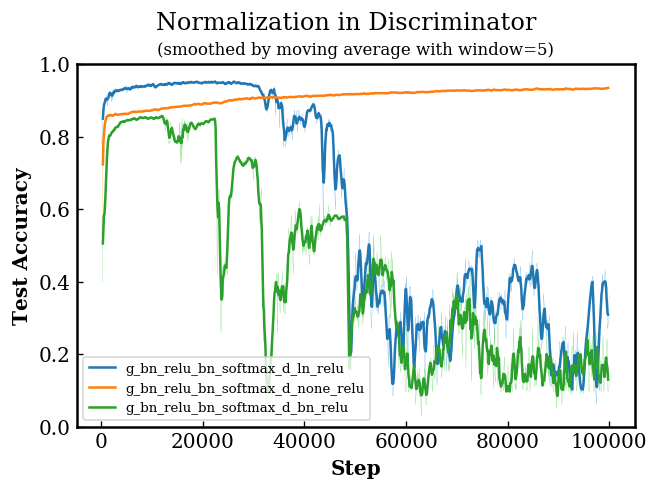

In [15]:
window = 5
for i in [0, 2, 7]:
    plot_acc_curve(test_steps[i], test_losses[i], smooth='avg', window=window, label=os.path.basename(EXP_DIRS[i]))
plt.gcf().suptitle('Normalization in Discriminator', y=0.99)
plt.ylim(0, 1)
plt.title('(smoothed by moving average with window={})'.format(window), fontsize=10)
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Test Accuracy', fontweight='bold')
plt.tick_params(direction='in')
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.legend(prop={'size':8})
plt.savefig(os.path.join(RESULT_DIR, 'norm_in_d.{}'.format(EXTENSION)), bbox_inches='tight')
plt.show()